In [5]:
#py download-kline.py -t spot -s BTCUSDT -i 30m -y 2023 -m 07 -skip-daily 1 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import backtrader as bt
from zipfile import ZipFile

In [6]:
df = pd.read_csv(ZipFile("../data/spot/monthly/klines/BTCUSDT/30m/BTCUSDT-30m-2023-07.zip").open("BTCUSDT-30m-2023-07.csv"),parse_dates=True, names=["datetime","open","high","low","close","volume","close_time","quote_asset_volume","nr_of_trades","taker_buy_base_asset_volume","taker_buy_quote_asset_volume","ignore"])
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df = df.set_index("datetime")
print(df.head())

                         open      high       low     close     volume  \
datetime                                                                 
2023-07-01 00:00:00  30471.99  30533.56  30420.00  30516.01  639.14885   
2023-07-01 00:30:00  30516.00  30534.74  30462.00  30469.83  605.81508   
2023-07-01 01:00:00  30469.82  30484.31  30380.51  30422.00  803.60108   
2023-07-01 01:30:00  30422.00  30467.01  30405.56  30447.78  378.64205   
2023-07-01 02:00:00  30447.77  30501.46  30390.33  30498.65  374.75671   

                        close_time  quote_asset_volume  nr_of_trades  \
datetime                                                               
2023-07-01 00:00:00  1688171399999        1.948203e+07         18981   
2023-07-01 00:30:00  1688173199999        1.847919e+07         15450   
2023-07-01 01:00:00  1688174999999        2.445816e+07         23584   
2023-07-01 01:30:00  1688176799999        1.152767e+07         13256   
2023-07-01 02:00:00  1688178599999        1.14130

In [13]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        #print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 100000.00
Final Portfolio Value: 91131.48


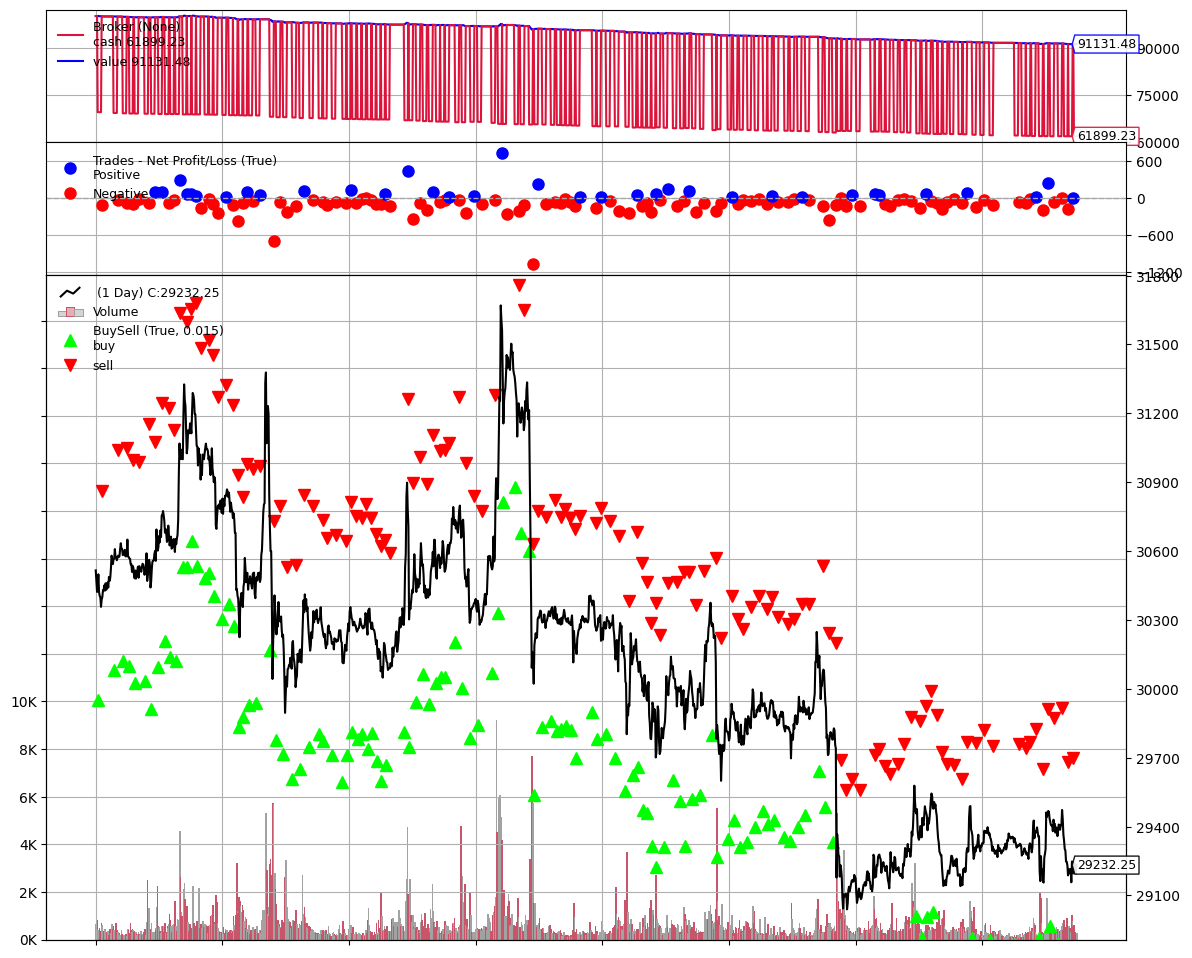

[[<Figure size 1200x1000 with 4 Axes>]]

In [14]:
%matplotlib inline
cerebro = bt.Cerebro()

cerebro.addstrategy(TestStrategy)

data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)

cerebro.broker.setcash(100000.0)

cerebro.broker.setcommission(commission=0.001)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


plt.rcParams['figure.figsize']=[12, 10]
cerebro.plot(iplot=False)